In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


2024-02-24 12:10:12.860514: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-24 12:10:13.389450: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 12:10:13.389551: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 12:10:13.391510: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-24 12:10:13.630561: I tensorflow/core/platform/cpu_feature_g

In [3]:
from tensorflow.keras.models import load_model

model_dict={}

model_path = '/data/projects/c04/cbd-saerts/nkemp/software/dev_DeepPeak/DeepPeak/checkpoints/mouse/basenji/checkpoints/14.keras'
model = load_model(model_path, compile=False)
model_dict['basenji']=model

model_path = '/data/projects/c04/cbd-saerts/nkemp/software/dev_DeepPeak/DeepPeak/checkpoints/mouse/bigboy/checkpoints/25.keras'
model = load_model(model_path, compile=False)
model_dict['bigboy']=model

model_path = '/data/projects/c04/cbd-saerts/nkemp/software/dev_DeepPeak/DeepPeak/checkpoints/mouse/gelu/checkpoints/40.keras'
model = load_model(model_path, compile=False)
model_dict['gelu']=model


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A100 80GB PCIe, compute capability 8.0


2024-02-24 12:10:24.904558: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79087 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:17:00.0, compute capability: 8.0


In [5]:
ids = np.load('/data/projects/c04/cbd-saerts/nkemp/software/dev_DeepPeak/DeepPeak/checkpoints/mouse/basenji/region_split_ids.npz')
test_ids = ids['test']
targets = np.load('/data/projects/c04/cbd-saerts/nkemp/software/dev_DeepPeak/DeepPeak/checkpoints/mouse/basenji/targets.npz')
test_targets = targets['test']


In [6]:
from pybedtools import BedTool
import pandas as pd

# Specify the path to your BED file
bed_file_path = '/data/projects/c04/cbd-saerts/nkemp/software/dev_DeepPeak/DeepPeak/checkpoints/mouse/basenji/regions.bed'

# Load the BED file into a DataFrame
bed_df = pd.read_csv(bed_file_path, sep='\t', header=None, names=['chrom', 'start', 'end', 'name'])
genome = '/data/projects/c04/cbd-saerts/nkemp/software/dev_DeepPeak/DeepPeak/data/raw/genome.fa'
bed_df

,chrom,start,end,name
0,chr1,3002851,3004965,chr1:3002851-3004965
1,chr1,3006384,3008498,chr1:3006384-3008498
2,chr1,3011672,3013786,chr1:3011672-3013786
3,chr1,3026341,3028455,chr1:3026341-3028455
4,chr1,3034849,3036963,chr1:3034849-3036963
...,...,...,...,...
1053806,chrY,90806689,90808803,chrY:90806689-90808803
1053807,chrY,90807780,90809894,chrY:90807780-90809894
1053808,chrY,90808460,90810574,chrY:90808460-90810574
1053809,chrY,90809864,90811978,chrY:90809864-90811978


In [7]:
import pyfaidx

def region_to_one_hot_encoding(
    chrom: str,
    start: int,
    end: int,
    genomic_pyfasta: pyfaidx.Fasta,
    hot_encoding_table: np.ndarray
) -> np.ndarray:
    """
    Encode the sequence associated with a specified region to a one-hot encoded numpy array.

    Args:
        chrom (str): Chromosome name.
        start (int): Start position of the region.
        end (int): End position of the region.
        genomic_pyfasta (pyfaidx.Fasta): Genome FASTA object for sequence retrieval.
        hot_encoding_table (np.ndarray): One-hot encoding reference table for nucleotide encoding.

    Returns:
        np.ndarray: One-hot encoded numpy array with shape (region length, alphabet size).
    """
    sequence = str(genomic_pyfasta[chrom][start:end].seq)
    sequence_bytes = np.frombuffer(sequence.encode('ascii'), dtype=np.uint8)
    encoded_sequence = hot_encoding_table[sequence_bytes]

    return np.expand_dims(encoded_sequence,axis=0)
def get_hot_encoding_table(
    alphabet: str = "ACGT",
    neutral_alphabet: str = "N",
    neutral_value: float = 0.0,
    dtype=np.float32,
) -> np.ndarray:
    """
    Get hot encoding table to encode a DNA sequence to a numpy array with shape
    (len(sequence), len(alphabet)) using bytes.
    """

    def str_to_uint8(string) -> np.ndarray:
        """
        Convert string to byte representation.
        """
        return np.frombuffer(string.encode("ascii"), dtype=np.uint8)

    # 255 x 4
    hot_encoding_table = np.zeros((np.iinfo(np.uint8).max, len(alphabet)), dtype=dtype)

    # For each ASCII value of the nucleotides used in the alphabet
    # (upper and lower case), set 1 in the correct column.
    hot_encoding_table[str_to_uint8(alphabet.upper())] = np.eye(
        len(alphabet), dtype=dtype
    )
    hot_encoding_table[str_to_uint8(alphabet.lower())] = np.eye(
        len(alphabet), dtype=dtype
    )

    # For each ASCII value of the nucleotides used in the neutral alphabet
    # (upper and lower case), set neutral_value in the correct column.
    hot_encoding_table[str_to_uint8(neutral_alphabet.upper())] = neutral_value
    hot_encoding_table[str_to_uint8(neutral_alphabet.lower())] = neutral_value

    return hot_encoding_table

genomic_pyfasta = pyfaidx.Fasta(genome, sequence_always_upper=True)
hot_encoding_table = get_hot_encoding_table()

In [8]:
classes_=['001 CLA-EPd-CTX Car3 Glut', '002 IT EP-CLA Glut','003 L5/6 IT TPE-ENT Glut', '004 L6 IT CTX Glut','005 L5 IT CTX Glut', '006 L4/5 IT CTX Glut','007 L2/3 IT CTX Glut', '008 L2/3 IT ENT Glut', '009 L2/3 IT PIR-ENTl Glut', '010 IT AON-TT-DP Glut',
       '011 L2 IT ENT-po Glut', '012 MEA Slc17a7 Glut','013 COAp Grxcr2 Glut', '014 LA-BLA-BMA-PA Glut','015 ENTmv-PA-COAp Glut', '016 CA1-ProS Glut', '017 CA3 Glut','018 L2 IT PPP-APr Glut', '019 L2/3 IT PPP Glut', '020 L2/3 IT RSP Glut', '021 L4 RSP-ACA Glut',
       '022 L5 ET CTX Glut', '023 SUB-ProS Glut', '025 CA2-FC-IG Glut','027 L6b EPd Glut', '028 L6b/CT ENT Glut', '029 L6b CTX Glut','030 L6 CT CTX Glut', '031 CT SUB Glut', '032 L5 NP CTX Glut','033 NP SUB Glut', '035 OB Eomes Ms4a15 Glut', '036 HPF CR Glut',
       '037 DG Glut', '038 DG-PIR Ex IMN', '039 OB Meis2 Thsd7b Gaba','040 OB Trdn Gaba', '041 OB-in Frmd7 Gaba','042 OB-out Frmd7 Gaba', '044 OB Dopa-Gaba','045 OB-STR-CTX Inh IMN', '046 Vip Gaba', '047 Sncg Gaba', '048 RHP-COA Ndnf Gaba', '049 Lamp5 Gaba', '050 Lamp5 Lhx6 Gaba',
       '051 Pvalb chandelier Gaba', '052 Pvalb Gaba', '053 Sst Gaba',
       '054 STR Prox1 Lhx6 Gaba', '055 STR Lhx8 Gaba',
       '056 Sst Chodl Gaba', '057 NDB-SI-MA-STRv Lhx8 Gaba',
       '058 PAL-STR Gaba-Chol', '059 GPe-SI Sox6 Cyp26b1 Gaba',
       '060 OT D3 Folh1 Gaba', '061 STR D1 Gaba', '062 STR D2 Gaba',
       '063 STR D1 Sema5a Gaba', '064 STR-PAL Chst9 Gaba',
       '066 NDB-SI-ant Prdm12 Gaba', '067 LSX Sall3 Pax6 Gaba',
       '068 LSX Otx2 Gaba', '069 LSX Nkx2-1 Gaba',
       '070 LSX Prdm12 Slit2 Gaba', '071 LSX Prdm12 Zeb2 Gaba',
       '072 LSX Sall3 Lmo1 Gaba', '073 MEA-BST Sox6 Gaba',
       '074 MEA-BST Lhx6 Sp9 Gaba', '076 MEA-BST Lhx6 Nfib Gaba',
       '079 CEA-BST Six3 Cyp26b1 Gaba', '080 CEA-AAA-BST Six3 Sp9 Gaba',
       '081 ACB-BST-FS D1 Gaba', '082 CEA-BST Ebf1 Pdyn Gaba',
       '085 SI-MPO-LPO Lhx8 Gaba', '086 MPO-ADP Lhx8 Gaba',
       '087 MPN-MPO-LPO Lhx6 Zfhx3 Gaba', '088 BST Tac2 Gaba',
       '089 PVR Six3 Sox3 Gaba', '090 BST-MPN Six3 Nrgn Gaba',
       '091 ARH-PVi Six6 Dopa-Gaba', '093 RT-ZI Gnb3 Gaba',
       '094 SCH Six6 Cdc14a Gaba', '095 DMH Prdm13 Gaba',
       '097 PVHd-SBPV Six3 Prox1 Gaba', '098 AHN-SBPV-PVHd Pdrm12 Gaba',
       '099 SBPV-PVa Six6 Satb2 Gaba', '100 AHN Onecut3 Gaba',
       '101 ZI Pax6 Gaba', '102 DMH-LHA Gsx1 Gaba',
       '104 TU-ARH Otp Six6 Gaba', '106 PVpo-VMPO-MPN Hmx2 Gaba',
       '109 LGv-ZI Otx2 Gaba', '111 TRS-BAC Sln Glut',
       '113 MEA-COA-BMA Ccdc42 Glut', '114 COAa-PAA-MEA Barhl2 Glut',
       '115 MS-SF Bsx Glut', '117 LHA Barhl2 Glut',
       '118 ADP-MPO Trp73 Glut', '119 SI-MA-LPO-LHA Skor1 Glut',
       '124 MPN-MPO-PVpo Hmx2 Glut', '126 ARH-PVp Tbx3 Glut',
       '128 VMH Fezf1 Glut', '129 VMH Nr5a1 Glut',
       '131 LHA-AHN-PVH Otp Trh Glut', '132 AHN-RCH-LHA Otp Fezf1 Glut',
       '133 PVH-SO-PVa Otp Glut', '134 PH-ant-LHA Otp Bsx Glut',
       '135 STN-PSTN Pitx2 Glut', '137 PH-an Pitx2 Glut',
       '138 PH Pitx2 Glut', '139 PH-LHA Foxb1 Glut',
       '141 PH-SUM Foxa1 Glut', '145 MH Tac2 Glut',
       '146 LH Pou4f1 Sox1 Glut', '147 AD Serpinb7 Glut',
       '148 AV Col27a1 Glut', '149 PVT-PT Ntrk1 Glut',
       '150 CM-IAD-CL-PCN Sema5b Glut', '151 TH Prkcd Grin2c Glut',
       '152 RE-Xi Nox4 Glut', '154 PF Fzd5 Glut', '155 PRC-PAG Pax6 Glut',
       '156 MB-ant-ve Dmrta2 Glut', '157 RN Spp1 Glut',
       '159 IF-RL-CLI-PAG Foxa1 Glut', '160 PAG-SC Neurod2 Meis2 Glut',
       '161 PAG Pou4f3 Glut', '163 APN C1ql2 Glut', '164 APN C1ql4 Glut',
       '165 PAG-MRN Pou3f1 Glut', '167 PRC-PAG Tcf7l2 Irx2 Glut',
       '168 SPA-SPFm-SPFp-POL-PIL-PoT Sp9 Glut',
       '169 PAG-SC Pou4f1 Zic1 Glut', '170 PAG-MRN Tfap2b Glut',
       '171 PAG Pou4f1 Bnc2 Glut', '172 PAG Pou4f1 Ebf2 Glut',
       '173 PAG Pou4f2 Glut', '174 PAG Pou4f2 Mesi2 Glut',
       '175 SC Bnc2 Glut', '176 SCig Foxb1 Glut',
       '177 SCig-an-PPT Foxb1 Glut', '179 SCdg-PAG Tfap2b Glut',
       '180 SCiw Pitx2 Glut', '181 IC Tfap2d Maf Glut',
       '182 CUN-PPN Evx2 Meis2 Glut', '185 SCig Tfap2b Chrnb3 Glut',
       '187 SCsg Pde5a Glut', '188 SCop Sln Glut',
       '190 ND-INC Foxd2 Glut', '192 PPN-CUN-PCG Otp En1 Gaba',
       '194 MRN-VTN-PPN Pax5 Cdh23 Gaba', '195 SNr-VTA Pax5 Npas1 Gaba',
       '197 SNr Six3 Gaba', '198 IC Six3 En2 Gaba',
       '199 PAG-MRN-RN Foxa2 Gaba', '200 PAG-ND-PCG Onecut1 Gaba',
       '201 PAG-RN Nkx2-2 Otx1 Gaba', '202 PRT Tcf7l2 Gaba',
       '203 LGv-SPFp-SPFm Nkx2-2 Tcf7l2 Gaba', '204 SC Otx2 Gcnt4 Gaba',
       '205 SC-PAG Lef1 Emx2 Gaba', '206 SCm-PAG Cdh23 Gaba',
       '207 SCs Dmbx1 Gaba', '208 SC Lef1 Otx2 Gaba',
       '209 SCs Pax7 Nfia Gaba', '210 PRT Mecom Gaba',
       '211 SC Tnnt1 Gli3 Gaba', '212 SCs Lef1 Gli3 Gaba',
       '213 SCsg Gabrr2 Gaba', '215 SNc-VTA-RAmb Foxa1 Dopa',
       '216 MB-MY Tph2 Glut-Sero', '217 PB Lmx1a Glut',
       '221 LDT-PCG Vsx2 Lhx4 Glut', '222 PB Evx2 Glut',
       '224 PCG-PRNr Vsx2 Nkx6-1 Glut', '228 PSV Pvalb Lhx2 Glut',
       '230 PRNr Otp Nfib Glut', '231 IPN-LDT Vsx2 Nkx6-1 Glut',
       '235 PG-TRN-LRN Fat2 Glut', '238 NTS Phox2b Glut',
       '239 MARN-GRN Pyy Glut', '245 SPVI-SPVC Tlx3 Ebf3 Glut',
       '246 CU-ECU-SPVI Foxb1 Glut', '248 MV-SPIV Zic4 Neurod2 Glut',
       '253 IO Fgl2 Glut', '263 CS-RPO Meis2 Gaba',
       '264 PRNc Otp Gly-Gaba', '268 CS-PRNr-DR En1 Sox2 Gaba',
       '273 PDTg-PCG Pax6 Gaba', '277 DTN-LDT-IPN Otp Pax3 Gaba',
       '278 NLL Gata3 Gly-Gaba', '283 PRP Otp Gly-Gaba',
       '285 MY Lhx1 Gly-Gaba', '286 PPY-PGRNl Vip Glyc-Gaba',
       '290 MY Prox1 Lmo7 Gly-Gaba', '293 PAS-MV Ebf2 Gly-Gaba',
       '296 RPA Pax6 Hoxb5 Gly-Gaba', '300 PARN-MDRNd-NTS Gbx2 Gly-Gaba',
       '304 NTS-PARN Neurod2 Gly-Gaba',
       '306 SPVI-SPVC Sall3 Lhx1 Gly-Gaba', '311 CBX MLI Megf11 Gaba',
       '314 CB Granule Glut', '315 DCO UBC Glut', '316 Bergmann NN',
       '317 Astro-CB NN', '318 Astro-NT NN', '319 Astro-TE NN',
       '321 Astroependymal NN', '322 Tanycyte NN', '323 Ependymal NN',
       '325 CHOR NN', '326 OPC NN', '327 Oligo NN', '329 ABC NN',
       '330 VLMC NN', '331 Peri NN', '332 SMC NN', '333 Endo NN',
       '334 Microglia NN', '335 BAM NN']

In [20]:
seq_onehot.shape

(1, 2114, 4)

chrom                        chr1
start                   186489837
end                     186491951
name     chr1:186489837-186491951
Name: 80128, dtype: object
141
1/1 [==============================] - 0s 26ms/step


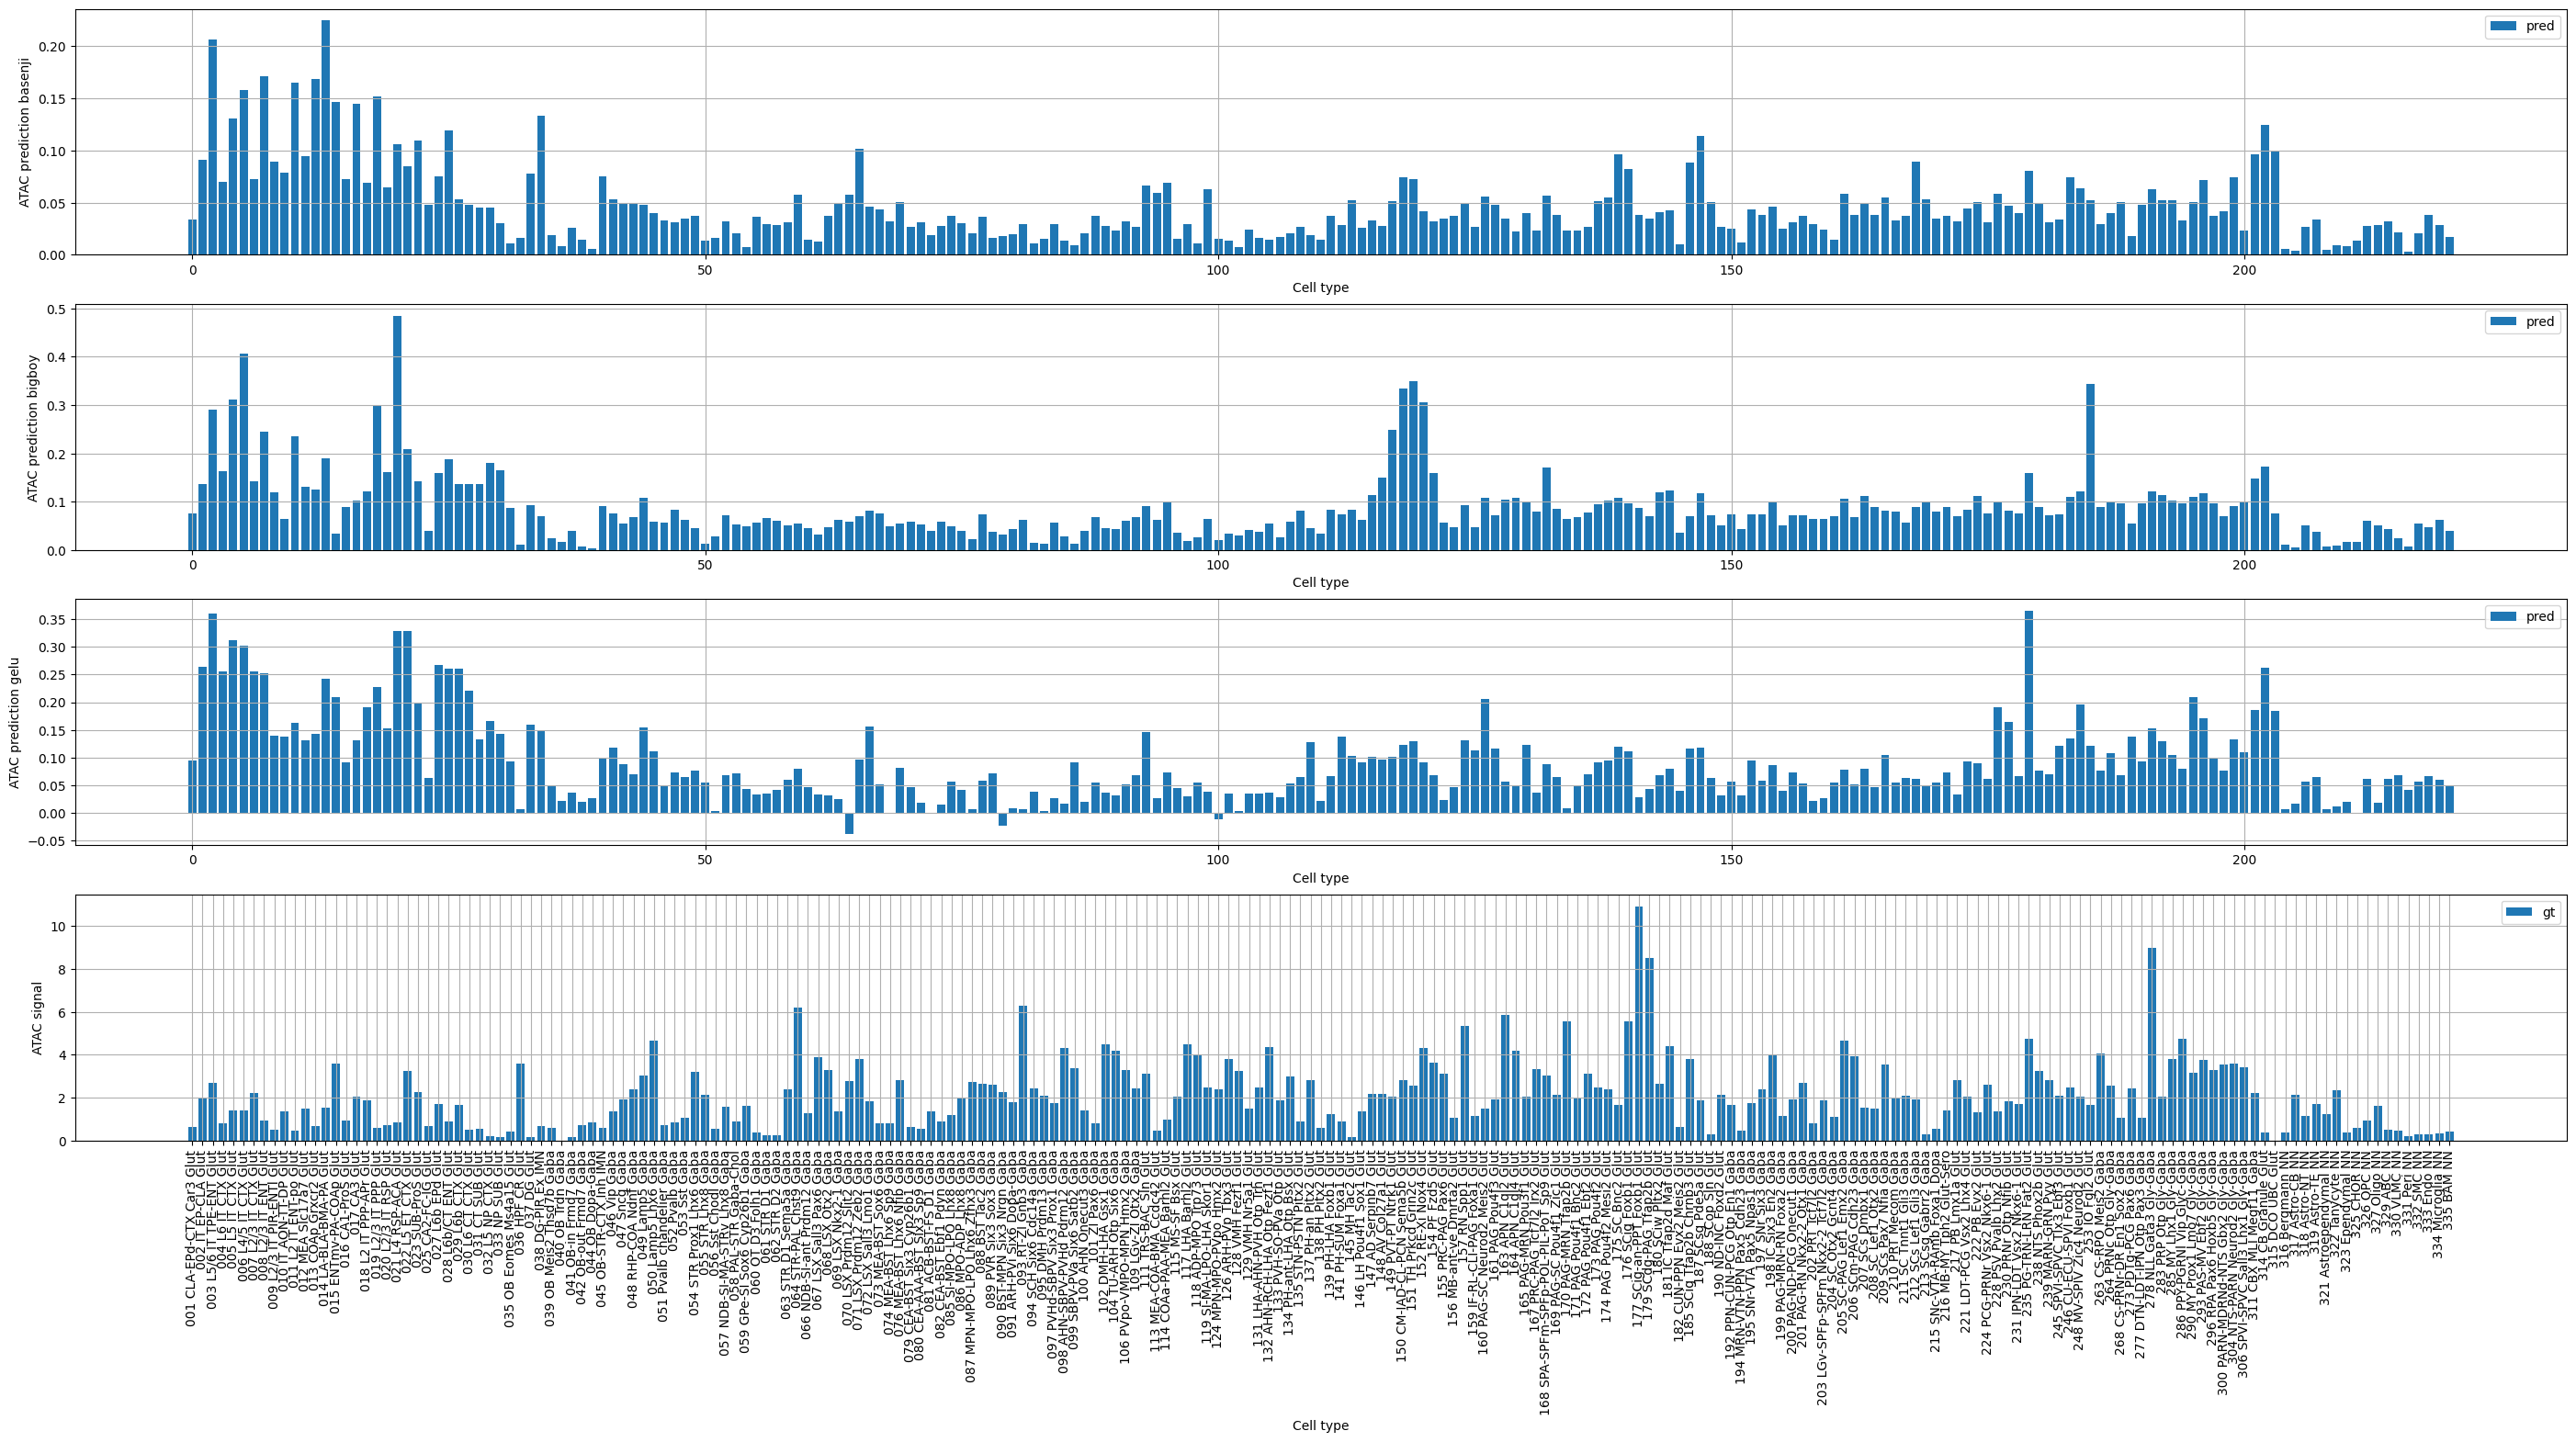

In [31]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
idx=80128
region = bed_df.iloc[idx]
seq_onehot = region_to_one_hot_encoding(region['chrom'],region['start'], region['end'], genomic_pyfasta, hot_encoding_table)

print(bed_df.iloc[idx])
#print(test_targets[idx:idx+1])
print(np.argmax(test_targets[idx:idx+1]))

#Prediction on a given region
ntrack = len(model_dict.keys())
fig = plt.figure(figsize=(35,5*ntrack+1))
for i, model in enumerate(model_dict):
    plt.subplot(ntrack+1,1,i+1)
    plt.bar(np.arange(0,len(classes_)), model_dict[model].predict(seq_onehot)[0], label='pred')
    plt.legend()
    plt.xlabel('Cell type')
    plt.ylabel('ATAC prediction '+model)
    plt.grid('on')
#plt.show()


plt.subplot(ntrack+1,1,ntrack+1)
plt.bar(classes_,test_targets[idx:idx+1][0], label='gt')
plt.xticks(rotation=90)
plt.legend()
plt.xlabel('Cell type')
plt.ylabel('ATAC signal')
plt.grid('on')
plt.show()

In [ ]:
import numpy as np
from tqdm import tqdm
from scipy.stats import spearmanr, pearsonr
from sklearn.metrics.pairwise import cosine_similarity

def regions_to_hot_encoding(
    regions_bed_filename: str,
    genomic_pyfasta: pyfaidx.Fasta,
    hot_encoding_table: np.ndarray,
    idx: np.ndarray = None,
):
    """
    Encode the seqeunce associated with each region in regions_bed_filename
    to a hot encoded numpy array with shape (len(sequence), len(alphabet)).

    Args:
        regions_bed_filename (str): Path to regions BED file.
        genomic_pyfasta (pyfaidx.Fasta): Genome FASTA object.
        hot_encoding_table (np.ndarray): One hot encoding reference table.
        idx (np.ndarray, optional): Index of regions to one hot encode. If None,
        all regions will be one hot encoded.
    """

    def _get_regions_from_bed(regions_bed_filename: str, idx: np.ndarray) -> list:
        """
        Read BED file and return a list of regions (chrom, start, end).
        """
        regions = []
        with open(regions_bed_filename, "r") as fh_bed:
            for i, line in enumerate(fh_bed):
                line = line.rstrip("\r\n")
                if line.startswith("#"):
                    continue
                if idx is not None and i not in idx:
                    continue

                columns = line.split("\t")
                chrom = columns[0]
                start, end = [int(x) for x in columns[1:3]]
                regions.append((chrom, start, end))
        return regions

    regions = _get_regions_from_bed(regions_bed_filename, idx)
    n_regions = len(regions)
    if n_regions == 0:
        raise ValueError("No regions found for this specification")
    region_width = regions[0][2] - regions[0][1]
    num_alphabets = hot_encoding_table.shape[1]

    # Initialize the array
    seq_one_hot = np.zeros((n_regions, region_width, num_alphabets))

    # Fill in the one-hot encoded sequences
    print("One hot encoding sequences...")
    for i, (chrom, start, end) in tqdm(enumerate(regions), total=n_regions):
        sequence = str(genomic_pyfasta[chrom][start:end].seq)
        sequence_bytes = np.frombuffer(sequence.encode("ascii"), dtype=np.uint8)
        encoded_sequence = hot_encoding_table[sequence_bytes]

        # Adjust this part if regions have varying widths
        seq_one_hot[i, : encoded_sequence.shape[0], :] = encoded_sequence

    return seq_one_hot

seqs = regions_to_hot_encoding(regions_bed_filename=bed_file_path,genomic_pyfasta=genomic_pyfasta, hot_encoding_table=hot_encoding_table)

# Assuming model_dict, seqs_one_hot, target_vector, and classes_biccn are defined

# Initialize dictionaries to store the correlation scores and predicted values
correlation_scores_spearman_incl_zeros = {}
correlation_scores_spearman_excl_zeros = {}
correlation_scores_pearson = {}
predicted_values = {}  # Store the predicted values for each model
cosine_similarity_scores = {}  # Store the cosine similarity scores for each model

for model_name, model in model_dict.items():
    if model_name in model_dict.keys():
        scores_spearman_incl_zeros = []
        scores_spearman_excl_zeros = []
        scores_pearson = []

        print('predicting')
        predictions = model.predict(seqs[test_ids])  # Calculate the predictions once
        predicted_values[model_name] = predictions
        print('preds done')

        for i, bw in enumerate(classes_):
            true_values = test_targets[:, i]

            # Spearman (including zeros)
            spearman_score_incl_zeros, _ = spearmanr(predictions[:, i], true_values)
            scores_spearman_incl_zeros.append(spearman_score_incl_zeros)

            # Spearman (excluding zeros)
            non_zero_indices = np.nonzero(true_values)[0]  # Adjust for correct indexing
            if len(non_zero_indices) > 0:
                spearman_score_excl_zeros, _ = spearmanr(predictions[non_zero_indices, i], true_values[non_zero_indices])
                scores_spearman_excl_zeros.append(spearman_score_excl_zeros)
            else:
                scores_spearman_excl_zeros.append(np.nan)  # Append NaN if there are no non-zero indices

            # Pearson (including zeros)
            pearson_score, _ = pearsonr(predictions[:, i], true_values)
            scores_pearson.append(pearson_score)

        correlation_scores_spearman_incl_zeros[model_name] = scores_spearman_incl_zeros
        correlation_scores_spearman_excl_zeros[model_name] = scores_spearman_excl_zeros
        correlation_scores_pearson[model_name] = scores_pearson
        
        # Cosine Similarity - calculate for the overall predictions vs. true values
        # Note: Ensure predictions and target_vector are properly aligned and reshaped if necessary
        cosine_sims = [cosine_similarity(predictions[i:i+1], test_targets[i:i+1])[0, 0] for i in range(predictions.shape[0])]
        
        # Calculate the average cosine similarity per sample
        average_cosine_sim = np.mean(cosine_sims)
        cosine_similarity_scores[model_name] = average_cosine_sim
        print('model done')


One hot encoding sequences...


 37%|███▋      | 392336/1053811 [00:36<01:27, 7525.24it/s] 